# Binary Presence Evaluations

This notebook contains three different evaluations of the binary presence:
- **Evaluation 1**: Binary Presence vs. counts.
- **Evaluation 2**: Effect of detections vs. ground truth.
- **Evaluation 3**: Effect of only active objects vs. all objects.
- **Evaluation 4**: Effect of weighted active objects.

In [1]:
import os

import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import egoviz.models.evaluation as ev
import egoviz.models.processing as pr
import egoviz.visualize as viz

SEED = 42

pd.set_option("display.max_rows", 300)
cwd = os.getcwd()

### Evaluation 1: Sum of Object Binary Presence vs. Sum of Object Counts

In [2]:
# create counts df
data = pr.load_pickle(os.path.join(cwd, '../data/home_data_all_preds.pkl'))
df = pr.generate_df_from_preds(data)
df_counts = pr.generate_counts_df(df)

# create binary df
data = pr.load_pickle(os.path.join(cwd, '../data/home_data_all_preds_df.pkl'))
df_binary = pr.generate_binary_presence_df(data)

# row wise min max scaling to prevent learning the number of objects vs. proportion of objects
df_binary_scaled = pr.row_wise_min_max_scaling(df_binary)
df_counts_scaled = pr.row_wise_min_max_scaling(df_counts)

In [3]:
# prepare data for evaluation
label_encoder = LabelEncoder()

models_binary = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

models_counts = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

results_binary, results_binary_df = ev.evaluate_models(models_binary, df_binary_scaled, label_encoder)
results_counts, results_counts_df = ev.evaluate_models(models_counts, df_counts_scaled, label_encoder)

2024-03-06 13:45:58,094 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:46:03,707 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:47:04,866 - root - INFO - LOGOCV complete for GradientBoostingClassifier
2024-03-06 13:47:10,226 - root - INFO - LOGOCV complete for XGBClassifier
2024-03-06 13:47:13,828 - root - INFO - LOGOCV complete for MLPClassifier
2024-03-06 13:47:14,363 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:47:23,019 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:49:46,427 - root - INFO - LOGOCV complete for GradientBoostingClassifier
2024-03-06 13:49:54,456 - root - INFO - LOGOCV complete for XGBClassifier
2024-03-06 13:49:59,694 - root - INFO - LOGOCV complete for MLPClassifier


In [4]:
ev.display_median_table(results_binary_df)

,model,median_accuracy,median_precision,median_recall,median_f1
0,GradientBoostingClassifier,0.707480,0.864509,0.707480,0.770466
1,LogisticRegression,0.750389,0.886622,0.750389,0.811589
2,MLPClassifier,0.733749,0.888139,0.733749,0.799306
3,RandomForestClassifier,0.751269,0.909298,0.751269,0.814956
4,XGBClassifier,0.718254,0.896062,0.718254,0.799526


In [5]:
ev.display_pct_table(results_binary_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.770466,0.725334,0.179233,0.88
1,LogisticRegression,0.811589,0.784882,0.119884,1.00
2,MLPClassifier,0.799306,0.735666,0.209173,0.81
3,RandomForestClassifier,0.814956,0.704399,0.246006,0.81
4,XGBClassifier,0.799526,0.746184,0.172922,0.88


In [6]:
ev.display_median_table(results_counts_df)

,model,median_accuracy,median_precision,median_recall,median_f1
0,GradientBoostingClassifier,0.721436,0.849797,0.721436,0.765481
1,LogisticRegression,0.723444,0.840931,0.723444,0.765218
2,MLPClassifier,0.714246,0.857375,0.714246,0.763343
3,RandomForestClassifier,0.706035,0.881262,0.706035,0.758928
4,XGBClassifier,0.689936,0.822191,0.689936,0.738499


In [7]:
ev.display_pct_table(results_counts_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.765481,0.700563,0.198417,0.88
1,LogisticRegression,0.765218,0.732107,0.132370,0.94
2,MLPClassifier,0.763343,0.693617,0.182379,0.81
3,RandomForestClassifier,0.758928,0.698988,0.226012,0.81
4,XGBClassifier,0.738499,0.700221,0.195188,0.88


#### Conclusions

LogisticRegression performs best with a median F1-score of 0.578817 and 75% of groups above the 0.50 threshold, indicating its effectiveness when using binary presence data. The RandomForestClassifier and MLPClassifier also show reasonable performance, with median F1-scores above 0.50 and half of the groups exceeding the 0.50 F1-score threshold. However, XGBClassifier stands out with the highest median F1-score of 0.586012 and 62% of groups above the 0.50 threshold using count-based data. The GradientBoostingClassifier also shows improved performance with total occurrences (median F1-score: 0.521464) compared to binary presence. However, this may indicate that the Gradient Boosting models are more reliant on correctly detected objects. So lets test this hypothesis by looking at the effect of detections vs. ground truth.

> Going forward, we use binary presence for all classifiers except gradient boosting.

### Evaluation 2: Effect of Detections vs. Ground Truth (Binary Presence)

In [8]:
eval_data = pr.load_pickle(os.path.join(cwd, '../data/home_data_eval_all_preds.pkl'))

df_detections = pd.DataFrame(columns=['video', 'frame', 'classes', 'active', 'adl'])
df_ground_truth = pd.DataFrame(columns=['video', 'frame', 'classes', 'active', 'adl'])

for id, dets in eval_data.items():
    adl = id.split('_', 1)[0]
    video = id.split('_')[1]
    frame = id.split('_')[2]
    detected_classes = dets['detic_data']['labels']
    detected_active = dets['detic_data']['active']
    ground_truth_classes = dets['ground_truth']['labels']
    ground_truth_active = dets['ground_truth']['active']

    detected_row = {'video': video, 'frame': frame, 'classes': detected_classes, 'active': detected_active, 'adl': adl}
    ground_truth_row = {'video': video, 'frame': frame, 'classes': ground_truth_classes, 'active': ground_truth_active, 'adl': adl}

    df_detections.loc[len(df_detections)] = detected_row
    df_ground_truth.loc[len(df_ground_truth)] = ground_truth_row

# make sure they are not the same
assert not df_detections.equals(df_ground_truth)

In [9]:
df_detections_counts = pr.generate_counts_df(df_detections)
df_ground_truth_counts = pr.generate_counts_df(df_ground_truth)

df_detections_binary = pr.generate_binary_presence_df(df_detections)
df_ground_truth_binary = pr.generate_binary_presence_df(df_ground_truth)

df_detections_binary_scaled = pr.row_wise_min_max_scaling(df_detections_binary)
df_ground_truth_binary_scaled = pr.row_wise_min_max_scaling(df_ground_truth_binary)

df_detections_counts_scaled = pr.row_wise_min_max_scaling(df_detections_counts)
df_ground_truth_counts_scaled = pr.row_wise_min_max_scaling(df_ground_truth_counts)

# make sure they are not the same
assert not df_detections_binary_scaled.equals(df_detections_counts_scaled)
assert not df_ground_truth_binary_scaled.equals(df_ground_truth_counts_scaled)

In [10]:
# prepare data for evaluation
label_encoder = LabelEncoder()

models_binary = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

models_counts = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

results_binary_dets, results_binary_dets_df = ev.evaluate_models(models_binary, df_detections_binary_scaled, label_encoder)
results_counts_dets, results_counts_dets_df = ev.evaluate_models(models_counts, df_detections_counts_scaled, label_encoder)

models_binary = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

models_counts = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

results_binary_gt, results_binary_gt_df = ev.evaluate_models(models_binary, df_ground_truth_binary_scaled, label_encoder)
results_counts_gt, results_counts_gt_df = ev.evaluate_models(models_counts, df_ground_truth_counts_scaled, label_encoder)


2024-03-06 13:50:00,858 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:50:02,034 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:50:11,173 - root - INFO - LOGOCV complete for GradientBoostingClassifier
2024-03-06 13:50:13,462 - root - INFO - LOGOCV complete for XGBClassifier
2024-03-06 13:50:13,703 - root - INFO - LOGOCV complete for MLPClassifier
2024-03-06 13:50:13,847 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:50:15,029 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:50:26,832 - root - INFO - LOGOCV complete for GradientBoostingClassifier
2024-03-06 13:50:29,057 - root - INFO - LOGOCV complete for XGBClassifier
2024-03-06 13:50:29,281 - root - INFO - LOGOCV complete for MLPClassifier
2024-03-06 13:50:29,415 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:50:30,499 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:50:36,558 - root - INFO - LOGO

In [11]:
ev.display_pct_table(results_binary_dets_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.607143,0.606824,0.186691,0.75
1,LogisticRegression,0.664286,0.649510,0.156398,0.75
2,MLPClassifier,0.238384,0.293883,0.246365,0.25
3,RandomForestClassifier,0.607292,0.579054,0.174455,0.62
4,XGBClassifier,0.569630,0.558437,0.207122,0.56


In [12]:
[(result.clf, result.auc) for result in results_binary_dets]

[('Logistic Regression', 0.8847538059117666),
 ('Random Forest', 0.8579018515231437),
 ('Gradient Boosting', 0.7679498643466341),
 ('XGBoost', 0.8236110105314469),
 ('MLP', 0.7007750645139115)]

In [13]:
ev.display_pct_table(results_binary_gt_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.608333,0.588606,0.173253,0.62
1,LogisticRegression,0.648148,0.622708,0.172171,0.69
2,MLPClassifier,0.295408,0.383793,0.281224,0.25
3,RandomForestClassifier,0.591667,0.616669,0.232513,0.56
4,XGBClassifier,0.617130,0.610392,0.234917,0.69


In [14]:
[(result.clf, result.auc) for result in results_binary_gt]

[('Logistic Regression', 0.8538363739050437),
 ('Random Forest', 0.8468472790357496),
 ('Gradient Boosting', 0.7379280202497865),
 ('XGBoost', 0.8377761634084273),
 ('MLP', 0.6347552465579837)]

#### Conclusions

The results show that the classifiers perform similarly whether using detections or ground truth. This indicates that the classifiers are not reliant on detections being really accurate to perform well. However, results show that some classifiers did perform better with the ground truth (i.e., RandomForestClassifier and MLPClassifier). Therefore, we invalidate our hypothesis that the Gradient Boosting models are more reliant on correctly detected objects. This may be due to the fact that we consolidated the objects from ~1200 down to 27 groups, which may have reduced the effect of detections vs. ground truth.

### Evaluation 3: Effect of Only Active Objects vs. All Objects (Binary Presence)

In [15]:
data = pr.load_pickle(os.path.join(cwd, '../data/home_data_all_preds_df.pkl'))

df_active = pr.generate_binary_presence_df(data)
df_inactive = df_active.drop(columns=[col for col in df_active.columns if 'active' in col])

df_binary_active_scaled = pr.row_wise_min_max_scaling(df_active)
df_binary_inactive_scaled = pr.row_wise_min_max_scaling(df_inactive)

data = pr.load_pickle(os.path.join(cwd, '../data/home_data_all_preds.pkl'))
df_counts = pr.generate_counts_df(pr.generate_df_from_preds(data))
df_counts_inactive = df_counts.drop(columns=[col for col in df_counts.columns if 'active' in col])

df_counts_active_scaled = pr.row_wise_min_max_scaling(df_counts)
df_counts_inactive_scaled = pr.row_wise_min_max_scaling(df_counts_inactive)

In [16]:
models_active = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

models_inactive = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

results_active, results_active_df = ev.evaluate_models(models_active, df_binary_active_scaled, label_encoder)
results_inactive, results_inactive_df = ev.evaluate_models(models_inactive, df_binary_inactive_scaled, label_encoder)

models_active_counts = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

models_inactive_counts = [
    ('Logistic Regression', LogisticRegression(max_iter=1000, random_state=SEED, class_weight='balanced')),
    ('Random Forest', RandomForestClassifier(random_state=SEED, class_weight='balanced')),
    ('Gradient Boosting', GradientBoostingClassifier(random_state=SEED)),
    ('XGBoost', XGBClassifier(random_state=SEED)),
    ('MLP', MLPClassifier(random_state=SEED, learning_rate='adaptive', max_iter=1000, early_stopping=True))
]

results_counts_active, results_counts_active_df = ev.evaluate_models(models_active_counts, df_counts_active_scaled, label_encoder)
results_counts_inactive, results_counts_inactive_df = ev.evaluate_models(models_inactive_counts, df_counts_inactive_scaled, label_encoder)

2024-03-06 13:51:11,688 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:51:17,457 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:52:18,350 - root - INFO - LOGOCV complete for GradientBoostingClassifier
2024-03-06 13:52:23,605 - root - INFO - LOGOCV complete for XGBClassifier
2024-03-06 13:52:27,170 - root - INFO - LOGOCV complete for MLPClassifier
2024-03-06 13:52:27,647 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:52:33,410 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:53:24,688 - root - INFO - LOGOCV complete for GradientBoostingClassifier
2024-03-06 13:53:29,252 - root - INFO - LOGOCV complete for XGBClassifier
2024-03-06 13:53:31,503 - root - INFO - LOGOCV complete for MLPClassifier
2024-03-06 13:53:32,036 - root - INFO - LOGOCV complete for LogisticRegression
2024-03-06 13:53:40,671 - root - INFO - LOGOCV complete for RandomForestClassifier
2024-03-06 13:56:06,391 - root - INFO - LOGO

In [17]:
ev.display_pct_table(results_active_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.770466,0.725334,0.179233,0.88
1,LogisticRegression,0.811589,0.784882,0.119884,1.00
2,MLPClassifier,0.799306,0.735666,0.209173,0.81
3,RandomForestClassifier,0.814956,0.704399,0.246006,0.81
4,XGBClassifier,0.799526,0.746184,0.172922,0.88


In [18]:
ev.display_pct_table(results_inactive_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.762649,0.697337,0.181800,0.81
1,LogisticRegression,0.762675,0.726209,0.151507,0.94
2,MLPClassifier,0.685295,0.647769,0.237041,0.81
3,RandomForestClassifier,0.709992,0.642909,0.240522,0.81
4,XGBClassifier,0.727006,0.691439,0.175654,0.88


In [19]:
[(result.clf, result.auc) for result in results_active], [(result.clf, result.auc) for result in results_inactive]

([('Logistic Regression', 0.944705415883279),
  ('Random Forest', 0.9283868490296463),
  ('Gradient Boosting', 0.9239299714264095),
  ('XGBoost', 0.9306687652152299),
  ('MLP', 0.9396684936427361)],
 [('Logistic Regression', 0.9291730802583055),
  ('Random Forest', 0.9105371170753065),
  ('Gradient Boosting', 0.9097523472125227),
  ('XGBoost', 0.9139775935061348),
  ('MLP', 0.9115096810728246)])

In [20]:
ev.display_pct_table(results_counts_active_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.765481,0.700563,0.198417,0.88
1,LogisticRegression,0.765218,0.732107,0.132370,0.94
2,MLPClassifier,0.763343,0.693617,0.182379,0.81
3,RandomForestClassifier,0.758928,0.698988,0.226012,0.81
4,XGBClassifier,0.738499,0.700221,0.195188,0.88


In [21]:
ev.display_pct_table(results_counts_inactive_df)

,model,median_f1,mean_f1,std_f1,pct_above_0.5
0,GradientBoostingClassifier,0.725213,0.662819,0.233104,0.81
1,LogisticRegression,0.739945,0.701867,0.140061,0.88
2,MLPClassifier,0.680514,0.654284,0.204407,0.81
3,RandomForestClassifier,0.733428,0.653191,0.219334,0.75
4,XGBClassifier,0.713960,0.669272,0.216977,0.81


In [22]:
[(result.clf, result.auc) for result in results_counts_active], [(result.clf, result.auc) for result in results_counts_inactive]

([('Logistic Regression', 0.9116002051267486),
  ('Random Forest', 0.9189743498595344),
  ('Gradient Boosting', 0.9222448661044066),
  ('XGBoost', 0.92156353516428),
  ('MLP', 0.9045917625897626)],
 [('Logistic Regression', 0.9020359983055634),
  ('Random Forest', 0.9056366423507453),
  ('Gradient Boosting', 0.9052805250181856),
  ('XGBoost', 0.9062981900168898),
  ('MLP', 0.8848598229343779)])

In [23]:
counts_active_minus_inactive = np.mean(
    ev.display_pct_table(results_counts_active_df)['mean_f1'] 
    - ev.display_pct_table(results_counts_inactive_df)['mean_f1']
)

binary_active_minus_inactive = np.mean(
    ev.display_pct_table(results_active_df)['mean_f1'] 
    - ev.display_pct_table(results_inactive_df)['mean_f1']
)

# print results and round to 3 decimals
print(f'Counts active minus inactive: {counts_active_minus_inactive:.3f}')
print(f'Binary active minus inactive: {binary_active_minus_inactive:.3f}')

Counts active minus inactive: 0.037
Binary active minus inactive: 0.058


In [24]:
binary_inactive_minus_counts_inactive = np.mean(
    ev.display_pct_table(results_inactive_df)['mean_f1'] 
    - ev.display_pct_table(results_counts_inactive_df)['mean_f1']
)

binary_active_minus_counts_active = np.mean(
    ev.display_pct_table(results_active_df)['mean_f1'] 
    - ev.display_pct_table(results_counts_active_df)['mean_f1']
)

# print results and round to 3 decimals
print(f'Binary inactive minus counts inactive: {binary_inactive_minus_counts_inactive:.3f}')
print(f'Binary active minus counts active: {binary_active_minus_counts_active:.3f}')

Binary inactive minus counts inactive: 0.013
Binary active minus counts active: 0.034


#### Conclusions

Results show pretty much across the board that including information about active objects improves the performance of the classifiers. This is expected since the active objects are the ones that are most likely to be informative about the activity being performed.

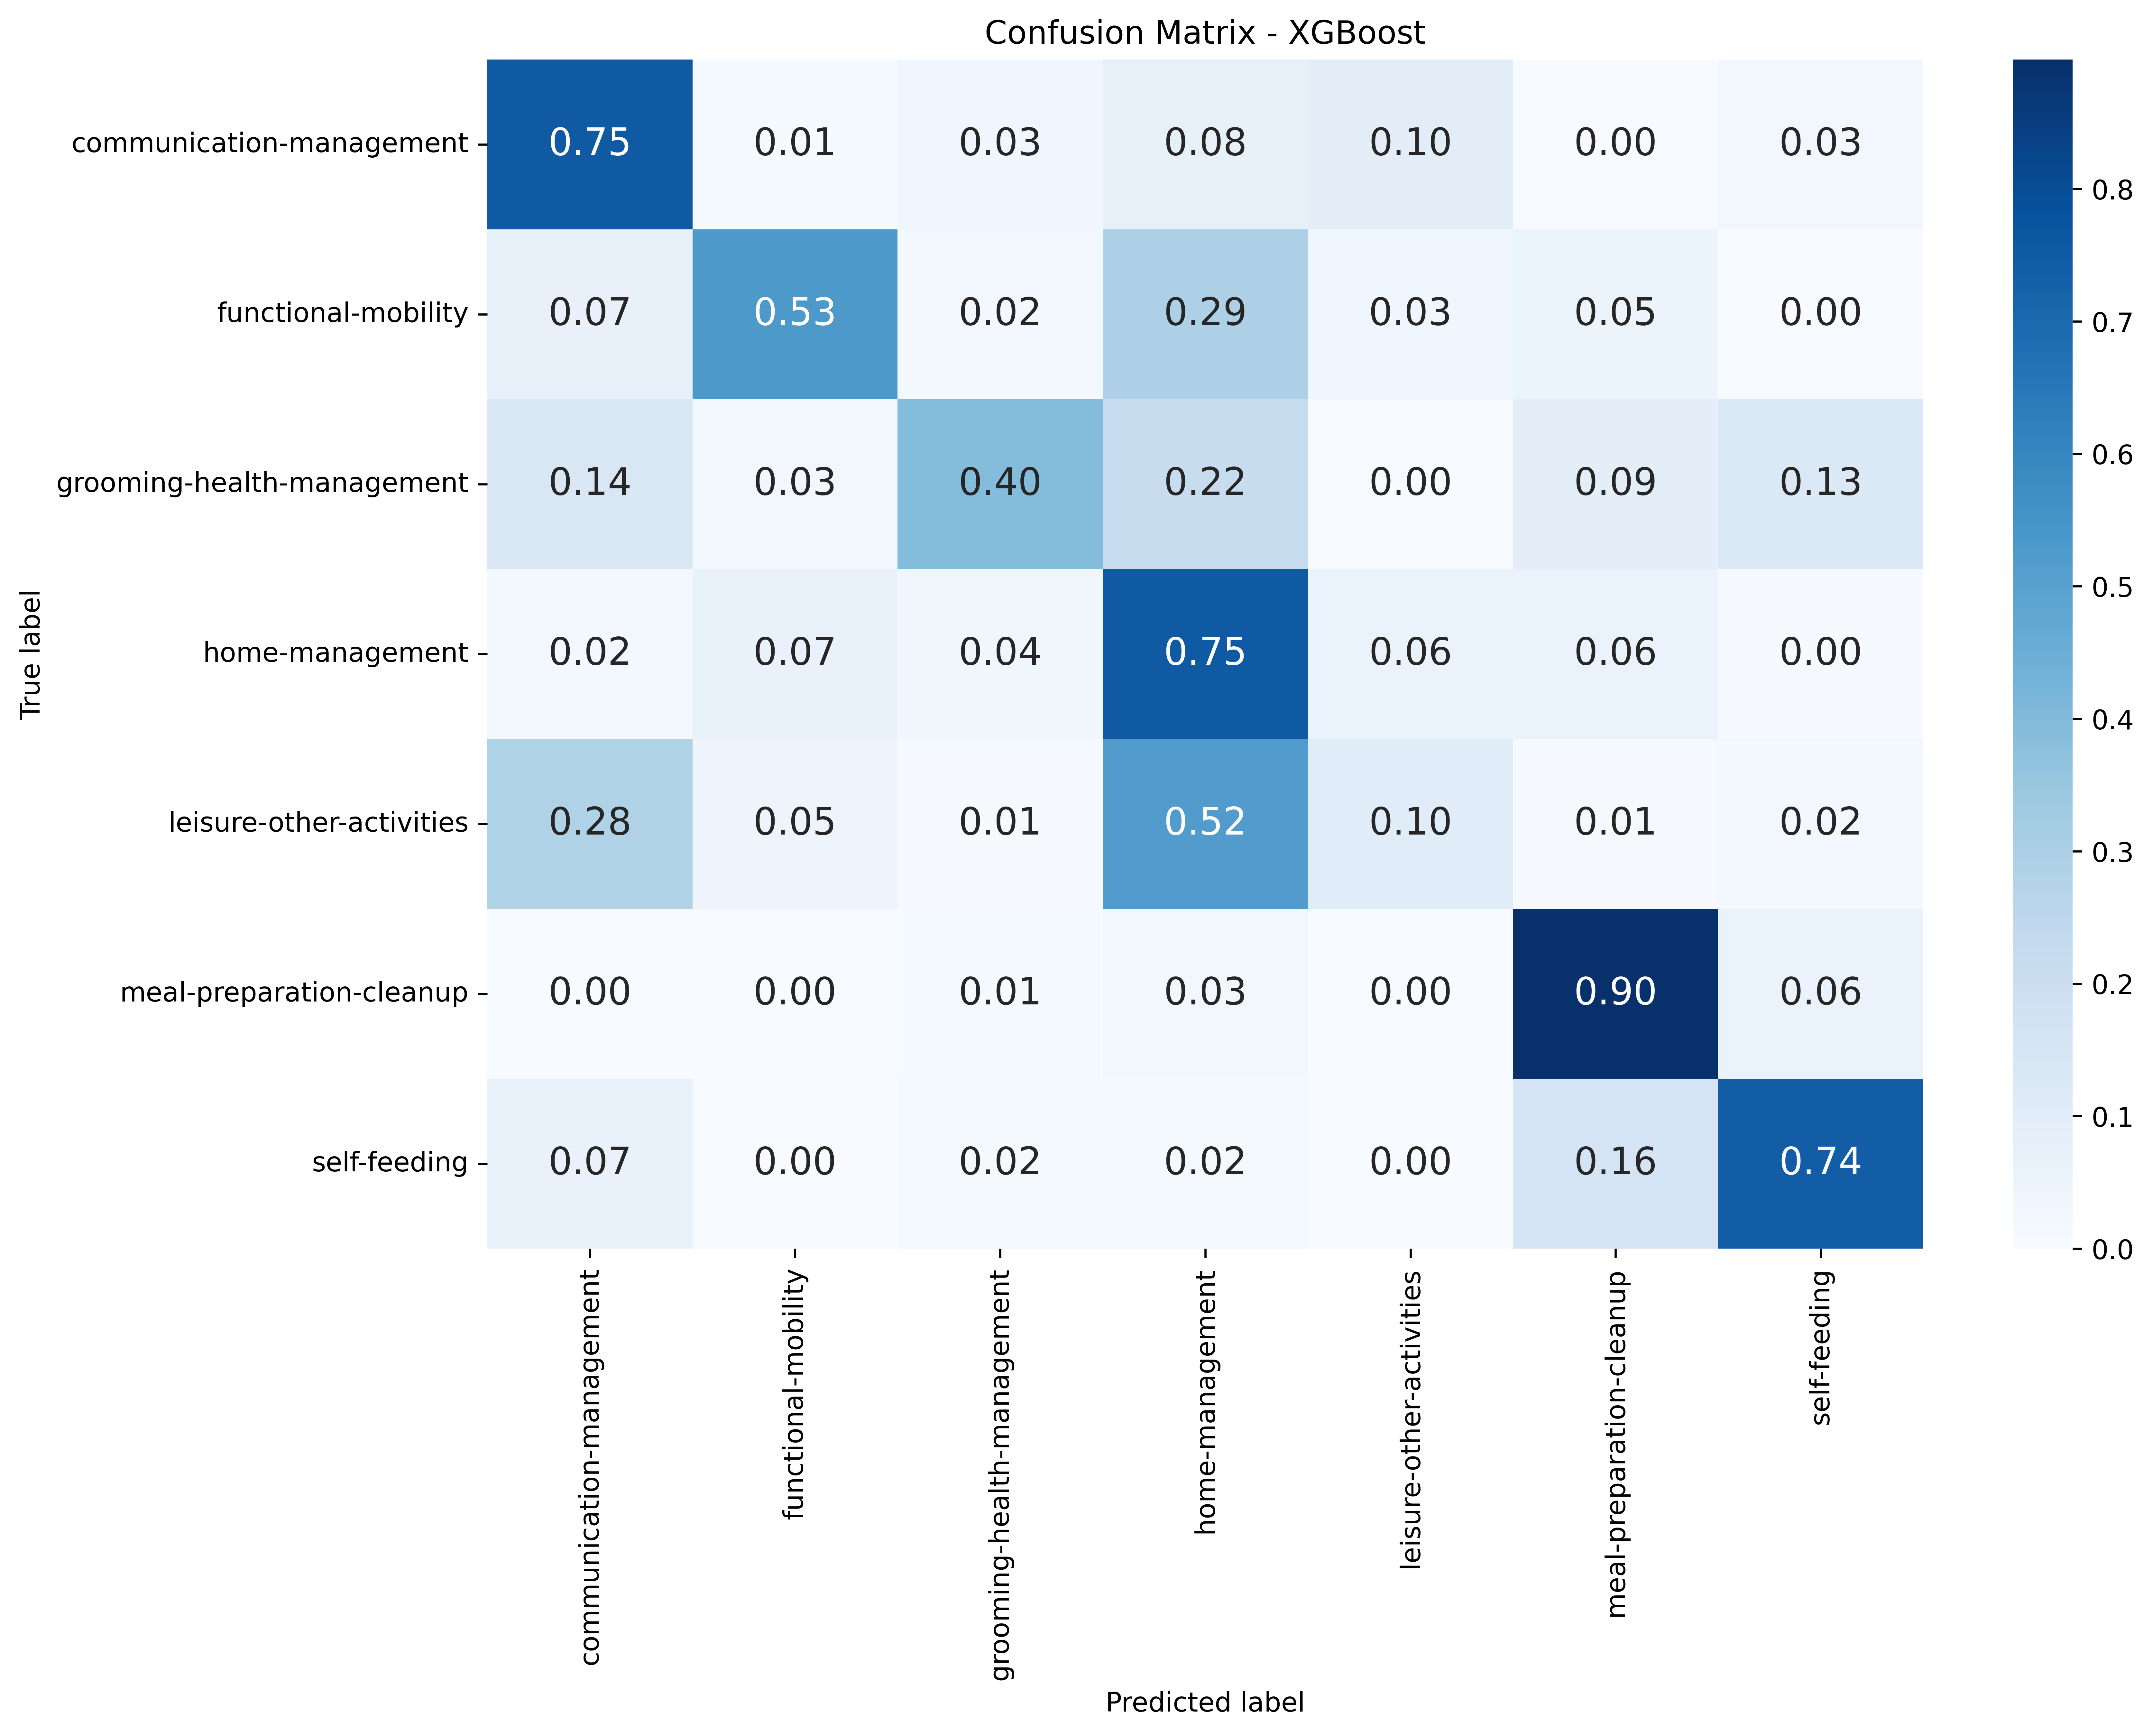

In [25]:
viz.plot_cm(results_active[3].cm, models_active[3][1], label_encoder, normalize=True, title='Confusion Matrix - XGBoost', figsize=(12,8))

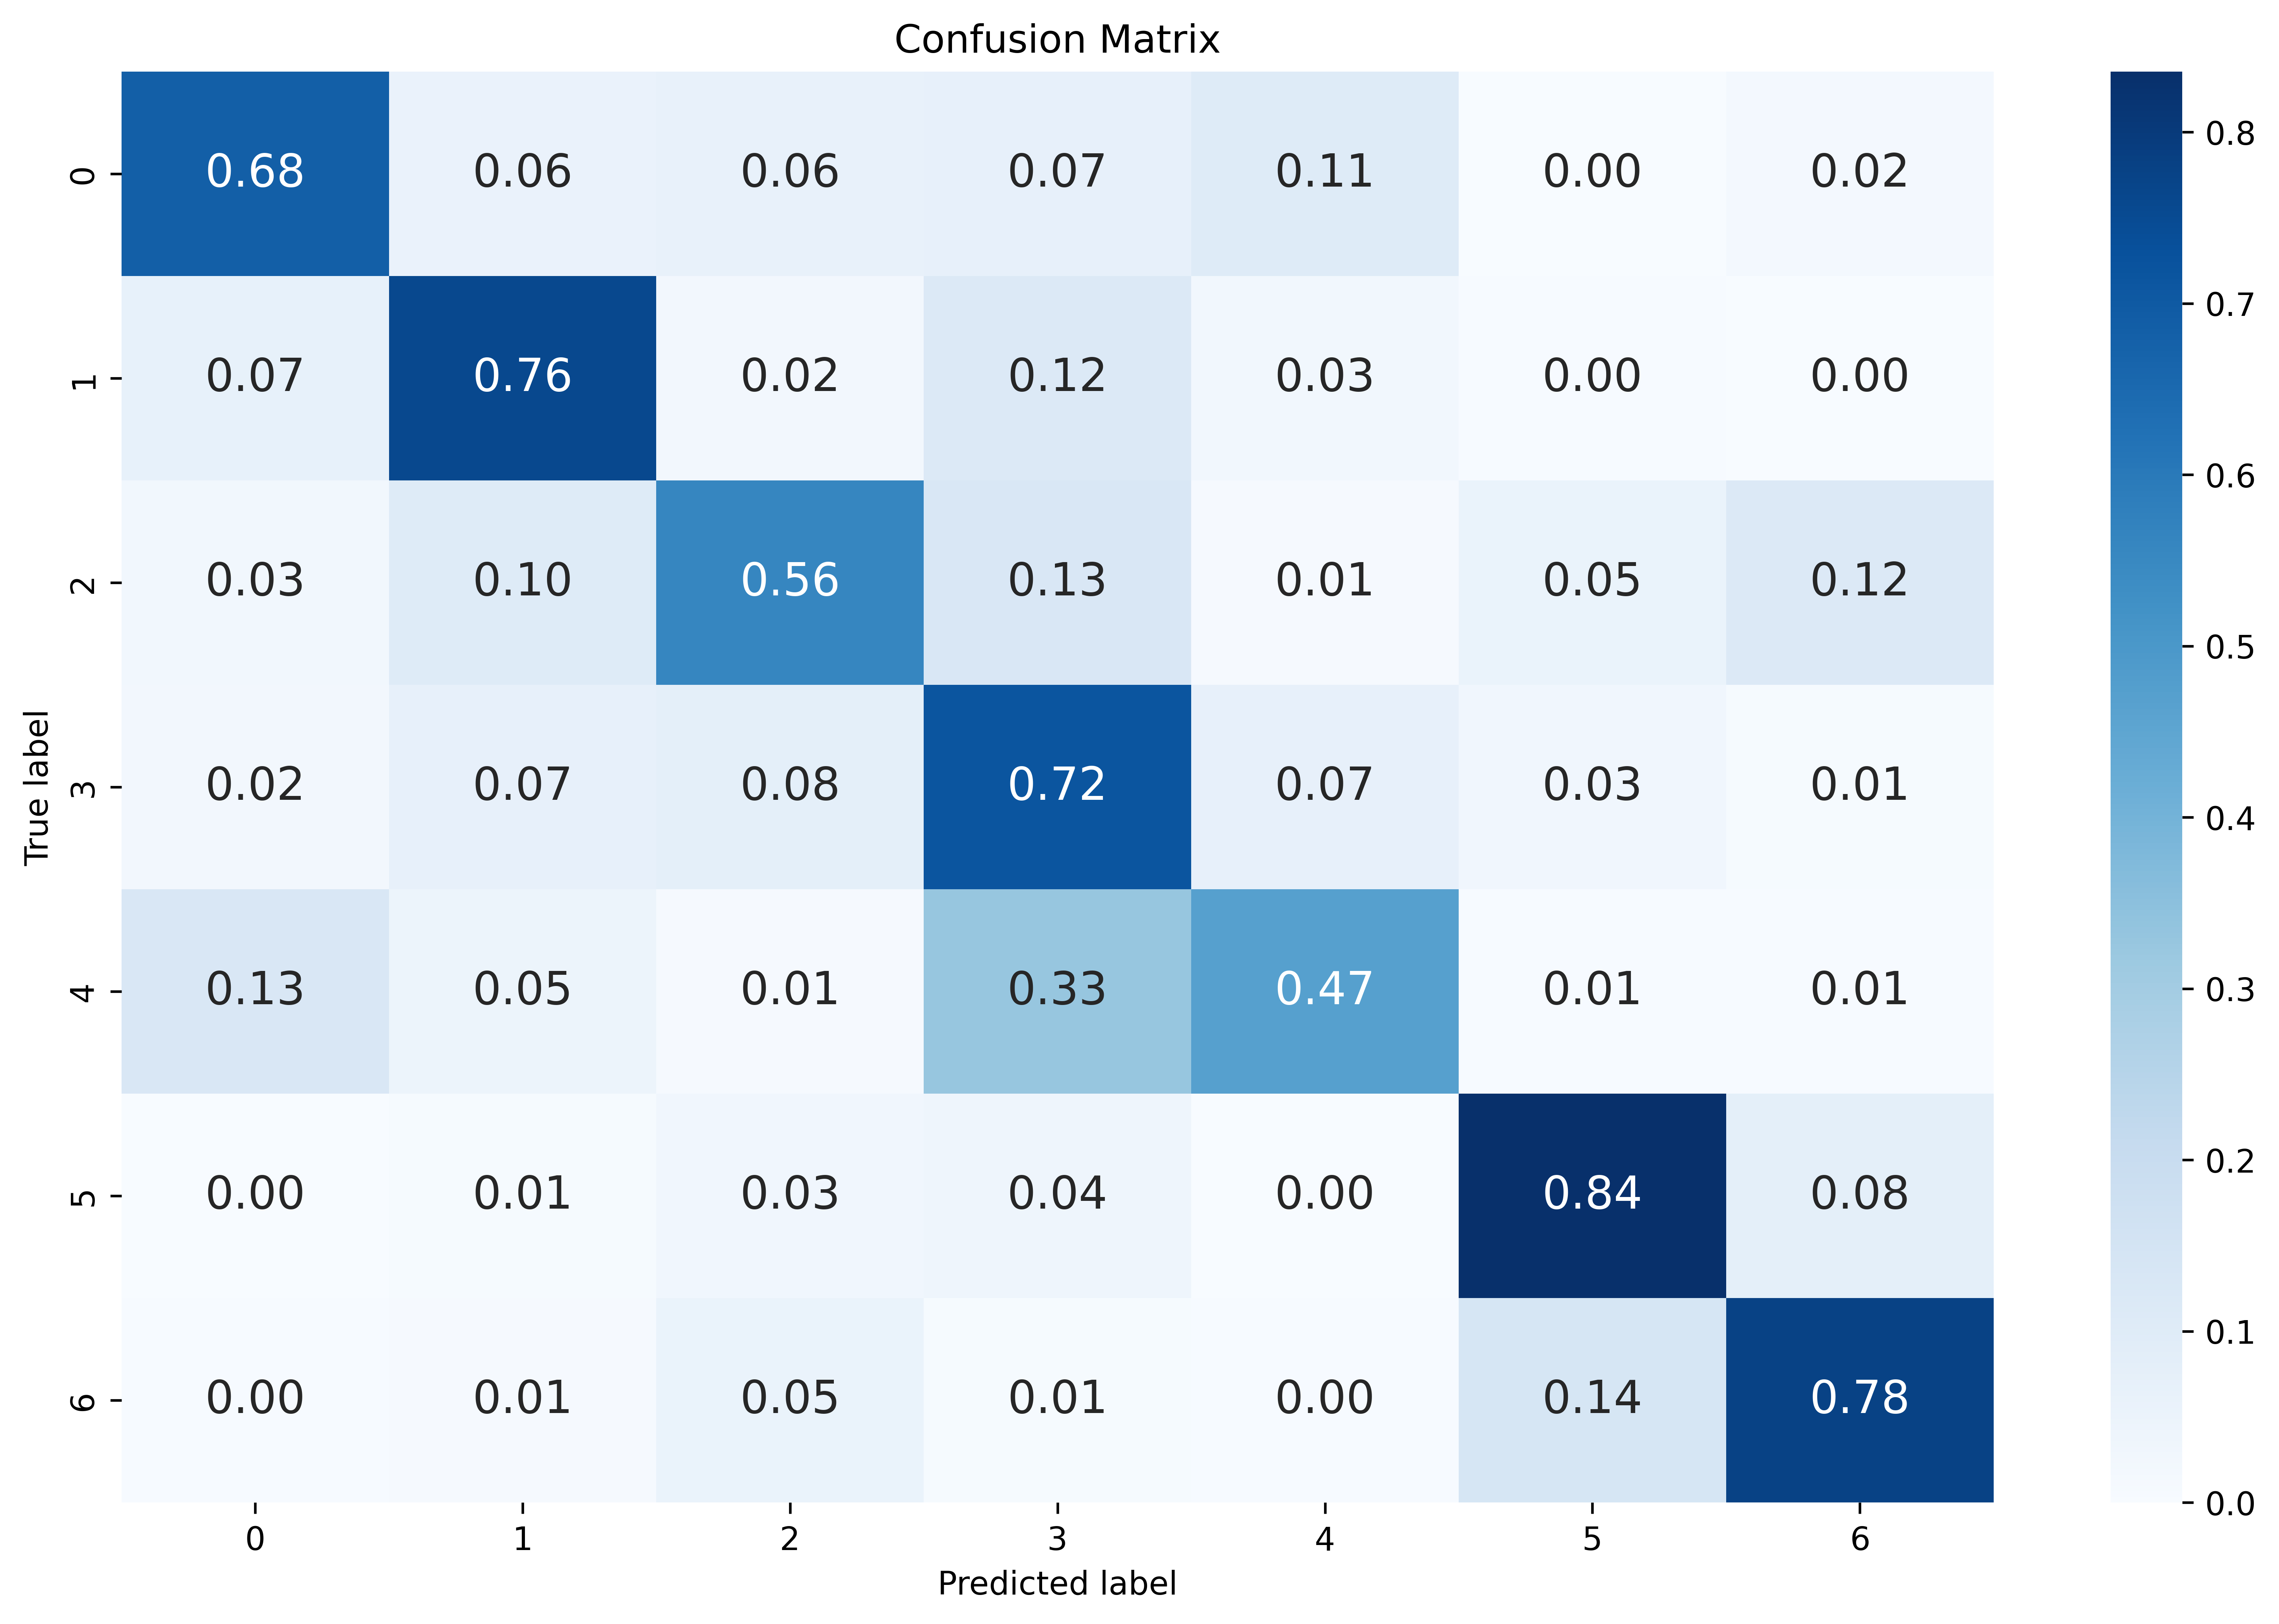

In [28]:
viz.plot_cm(results_active[0].cm, models_active[0][1], normalize=True, figsize=(13,8))